In [1]:
from pymongo import MongoClient
from konlpy.tag import Kkma
from konlpy import jvm
from soynlp.noun import LRNounExtractor_v2
from soynlp.word import WordExtractor
from multiprocessing import Process
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

### pyplot 폰트, 스타일설정

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 25
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'
plt.style.use('ggplot')

### 해당 분석은 오로지 데이터에 기반한 사실만으로 분석했고, 어떠한 정치적 견해도 포함되지 않았음을 알림.

# 2019 네이버 랭킹뉴스 분석
### Data Fields
- _id: database 내의 data id
- title: 뉴스 제목
- href: 뉴스 링크
- press: 언론사 이름
- section: 분야
> + 100: 정치
> + 101: 경제
> + 102: 사회
> + 103: 생활/문화
> + 104: 세계
> + 105: IT/과학
- views: 뉴스 조회수 <b>(같은 기사라도 날짜마다 조회수는 따로 계산)</b>
- comment: 뉴스 댓글수 <b>(같은 기사의 댓글수는 날짜가 달라도 중복)</b>
- year/month/day: 뉴스 날짜
<br><br>
- 기사에 대한 사람들의 반응
> + reaction_good   좋아요
> + reaction_warm   훈훈해요
> + reaction_sad    슬퍼요
> + reaction_angry  화나요
> + reaction_next   후속기사 원해요
![reaction_panel.PNG](./src/reaction_panel.PNG)
- 댓글작성자의 성별, 나이 비율
>  전체 댓글을 각 비율로 나누어 저장.
> + male: 남성의 댓글 수
> + female: 여성의 댓글 수
> + age_10~60: 각 연령층의 댓글 수, age_60은 60대 이상 포함
![chart.PNG](./src/chart.PNG)

In [3]:
client = MongoClient('localhost', 27017)
db = client["news"]
collection = db["article"]
count = collection.count_documents({})
f'2019년 랭킹뉴스 기사는 총: {count}개'

'2019년 랭킹뉴스 기사는 총: 65700개'

In [4]:
articles = pd.DataFrame(list(collection.find()))
df = articles.drop(axis=1,columns='_id')
df.shape

(65700, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65700 entries, 0 to 65699
Data columns (total 22 columns):
reaction_good     65698 non-null float64
reaction_warm     65698 non-null float64
reaction_sad      65698 non-null float64
reaction_angry    65698 non-null float64
reaction_next     65698 non-null float64
comment           65698 non-null float64
male              65698 non-null float64
female            65698 non-null float64
age_10            65698 non-null float64
age_20            65698 non-null float64
age_30            65698 non-null float64
age_40            65698 non-null float64
age_50            65698 non-null float64
age_60            65698 non-null float64
title             65700 non-null object
href              65700 non-null object
press             65700 non-null object
section           65700 non-null int64
views             65700 non-null int64
year              65700 non-null int64
month             65700 non-null int64
day               65700 non-null int64
dt

In [6]:
#섹션 이름을 번호에서 한글로 바꿈
section_label = ['정치', '경제', '사회', '생활/문화', '세계', 'IT/과학' ]
def change_section_to_str(section_id):
    return section_label[section_id-100]

df['section'] = df['section'].apply(change_section_to_str)
df.head()

,reaction_good,reaction_warm,reaction_sad,reaction_angry,reaction_next,comment,male,female,age_10,age_20,...,age_50,age_60,title,href,press,section,views,year,month,day
0,83.0,10.0,7.0,288.0,10.0,701.0,638.0,63.0,21.0,63.0,...,105.0,42.0,中탐사선 3일경 달 뒷면 착륙… 우주경쟁서 美 처음 제친다,https://news.naver.com/main/ranking/read.nhn?r...,동아일보,세계,170309,2019,1,1
1,1153.0,31.0,30.0,6395.0,59.0,5687.0,4493.0,1194.0,57.0,569.0,...,853.0,398.0,오늘부터 최저임금 8350원…근로자 500만명 인상 '역대 최대',https://news.naver.com/main/ranking/read.nhn?r...,뉴스1,사회,637054,2019,1,1
2,451.0,51.0,71.0,8127.0,125.0,8249.0,6434.0,1815.0,165.0,1402.0,...,990.0,330.0,"새해부터 최저임금 8350원, 주는 쪽도 받는 쪽도 불만인데…",https://news.naver.com/main/ranking/read.nhn?r...,JTBC,경제,758151,2019,1,1
3,76.0,8.0,11.0,111.0,32.0,242.0,169.0,73.0,2.0,41.0,...,24.0,15.0,[리포트+] SNS 연하장 시대…이런 메시지는 공해,https://news.naver.com/main/ranking/read.nhn?r...,SBS,생활/문화,308662,2019,1,1
4,142.0,10.0,6.0,25.0,21.0,150.0,126.0,24.0,8.0,16.0,...,32.0,18.0,태양계 끝 날고 소행성 궤도 진입…새해 우주서 잇단 '신기록',https://news.naver.com/main/ranking/read.nhn?r...,연합뉴스,IT/과학,76153,2019,1,1


### 2019년 랭킹뉴스 총 조회수, 댓글 수

In [7]:
# 2019년 랭킹뉴스 총 조회수, 댓글 개수
all_views = np.sum(df['views'])
all_comments = np.sum(df['comment'])
print(f"총 조회수: {all_views}, 총 댓글 수: {all_comments}")

총 조회수: 5498953034, 총 댓글 수: 52259308.0


### 댓글 나이, 성별비

<Figure size 720x720 with 0 Axes>

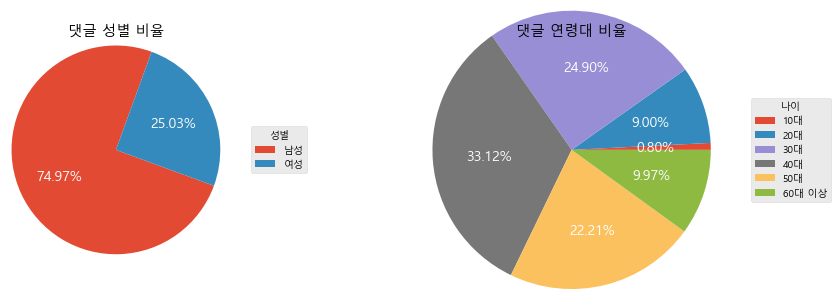

In [8]:
x1 = ['남성', '여성']
y1 = [np.sum(df.loc[df['male'] != -1]['male']), np.sum(df.loc[df['female'] != -1]['female'])]
x2 = ['10대', '20대', '30대', '40대', '50대', '60대 이상']
y2 = []
for age in range(10,70,10):
    age_str = f'age_{age}'
    y2.append(np.sum(df.loc[df[age_str] != -1][age_str]))
    
plt.figure(figsize=(10,10))
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(wspace=0.4)

wedges, texts, autotexts = ax1.pie(y1, startangle=70, autopct='%.2f%%',
                                   radius=1.2, textprops=dict(color="w", fontsize=14))
ax1.set_title('댓글 성별 비율')
ax1.legend(wedges, x1, title="성별",
          loc = "center left",
          bbox_to_anchor=(1.1,0,0.5,1))

wedges, texts, autotexts = ax2.pie(y2, autopct='%.2f%%',
                                   radius=1.6, textprops=dict(color="w", fontsize=14))
ax2.set_title('댓글 연령대 비율')
ax2.legend(wedges, x2, title="나이",
          loc = "center left",
          bbox_to_anchor=(1.3,0,0.5,1))

- 남성이 여성보다 댓글을 3배 정도 많이 달았다.
- 30,40,50대의 댓글 비율이 전체의 80% 이상이고, 10대는 거의 댓글을 달지 않았다.

### 섹션별 총 조회수 및 댓글수

<Figure size 864x720 with 0 Axes>

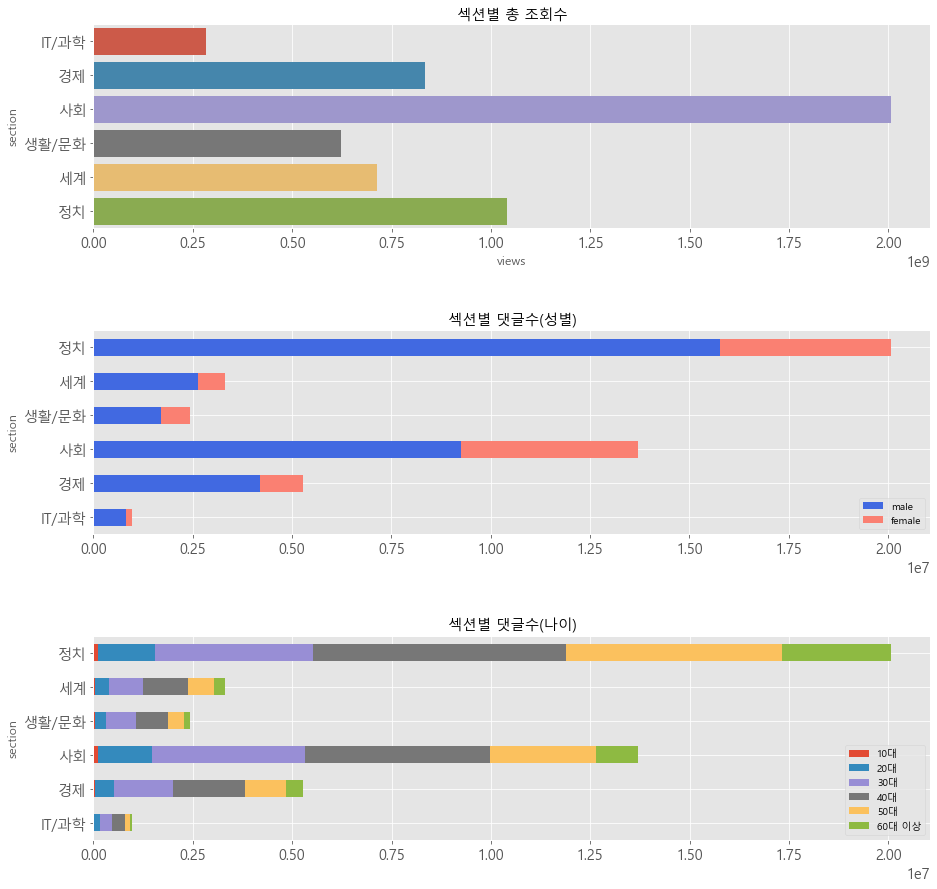

In [9]:
# section_views = []
# section_comments = []
# for section in section_label:
#     _views = np.sum(df[df['section'] == section]['views'])
#     _comments = np.sum(df[df['section'] == section]['comment'])
#     section_views.append(_views)
#     section_comments.append(_comments)

# temp_df = pd.DataFrame({'section': section_label,
#               'views': section_views,
#               'comments': section_comments})
# # temp_df = pd.melt(temp_df, id_vars=['section'])
# print(temp_df)

plt.figure(figsize=(12,10))
figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
plt.subplots_adjust(hspace=0.5)
figure.set_size_inches(15,15)

temp = df[['section','views']].groupby('section').sum().reset_index()
sns.barplot(y='section', x='views',data=temp, ax= ax1)
ax1.set_title("섹션별 총 조회수")

# 날짜가 다른 중복기사의 댓글은 같으므로 중복을 제거해야한다.
temp = df[['title','section','male','female']].drop_duplicates('title').drop(columns='title')
temp.loc[temp['male'] != -1].groupby('section').sum().plot.barh(stacked=True, color=['royalblue','salmon'], ax=ax2)
ax2.set_title("섹션별 댓글수(성별)")

# 날짜가 다른 중복기사의 댓글은 같으므로 중복을 제거해야한다.
temp = df[['title','section','age_10','age_20','age_30','age_40','age_50','age_60']].drop_duplicates('title').drop(columns='title')
temp.loc[temp['age_10'] != -1].groupby('section').sum().plot.barh(stacked=True,ax=ax3)
ax3.set_title("섹션별 댓글수(나이)")
ax3.legend(labels=['10대', '20대', '30대', '40대', '50대', '60대 이상'])

- 총 조회수는 사회섹션이 가장 많았고, 그 뒤로 정치, 경제, 세계, 생활/문화, IT/과학 순이다.
- 총 댓글수는 정치섹션이 가장 많았고, 그 뒤로 사회, 경제, 세계, 생활/문화, IT/과학 순이다.
- 정치, 사회섹션에서 여성독자들의 댓글작성이 가장 많았다.
- 위의 pie chart와 마찬가지로 대부분의 댓글작성자는 30대 이상이다.

### 섹션별 평균 조회수, 댓글수

Text(0.5, 1.0, '섹션별 평균 댓글수')

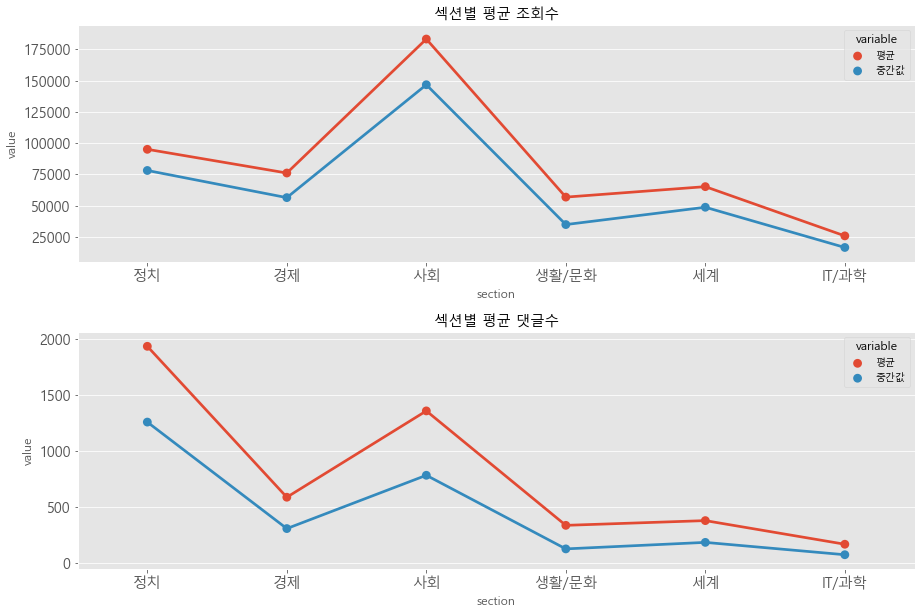

In [10]:
med = [[],[]]
avg = [[],[]]
_max = [[],[]]
for section in section_label:
    _views = df[df['section'] == section]['views'].dropna()
    _comments = df[df['section'] == section]['comment'].dropna()
    avg[0].append(np.average(_views))
    med[0].append(np.median(_views))
    _max[0].append(np.max(_views))
    avg[1].append(np.average(_comments))
    med[1].append(np.median(_comments))
    _max[1].append(np.max(_comments))

v_df = pd.DataFrame({'section': section_label,
                        #'최대': _max[0],   
                        '평균': avg[0],
                        '중간값': med[0],
                       })

c_df = pd.DataFrame({'section': section_label,
                        #'최대': _max[1],   
                        '평균': avg[1],
                        '중간값': med[1],
                       })
v_df = pd.melt(v_df, id_vars=['section'])
c_df = pd.melt(c_df, id_vars=['section'])

figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.3)
figure.set_size_inches(15,10)

sns.pointplot(x='section', y='value', hue='variable', ax= ax1, data=v_df)
ax1.set_title("섹션별 평균 조회수")

sns.pointplot(x='section', y='value', hue='variable', ax= ax2, data=c_df)
ax2.set_title("섹션별 평균 댓글수")

### 전체 기사 중 조회수 TOP 10

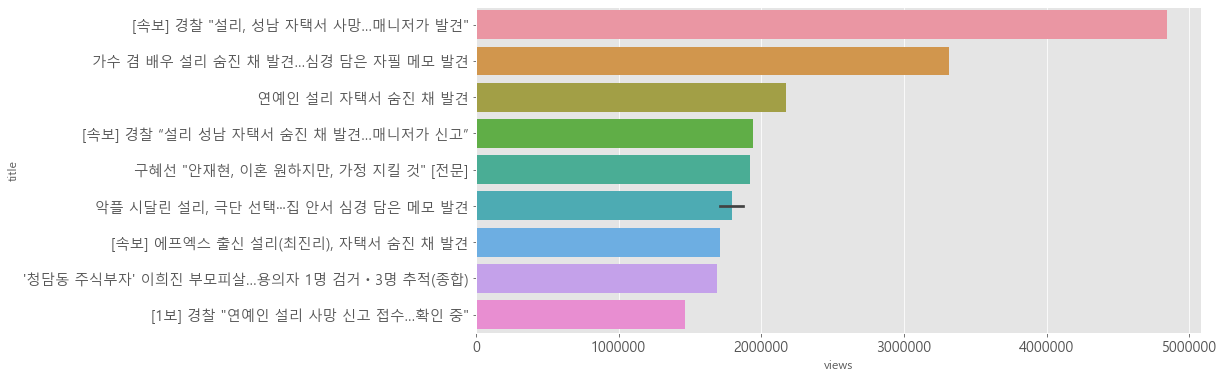

In [11]:
plt.figure(figsize=(13,6))
top_views = df.sort_values(by='views', ascending=False)
tv = top_views.head(10)[["title", "views"]]
sns.barplot(y="title", x="views", data=tv)

### 각 섹션별 조회수 TOP 10

In [12]:
for idx,section in enumerate(section_label):
    print(idx, section)

0 정치
1 경제
2 사회
3 생활/문화
4 세계
5 IT/과학


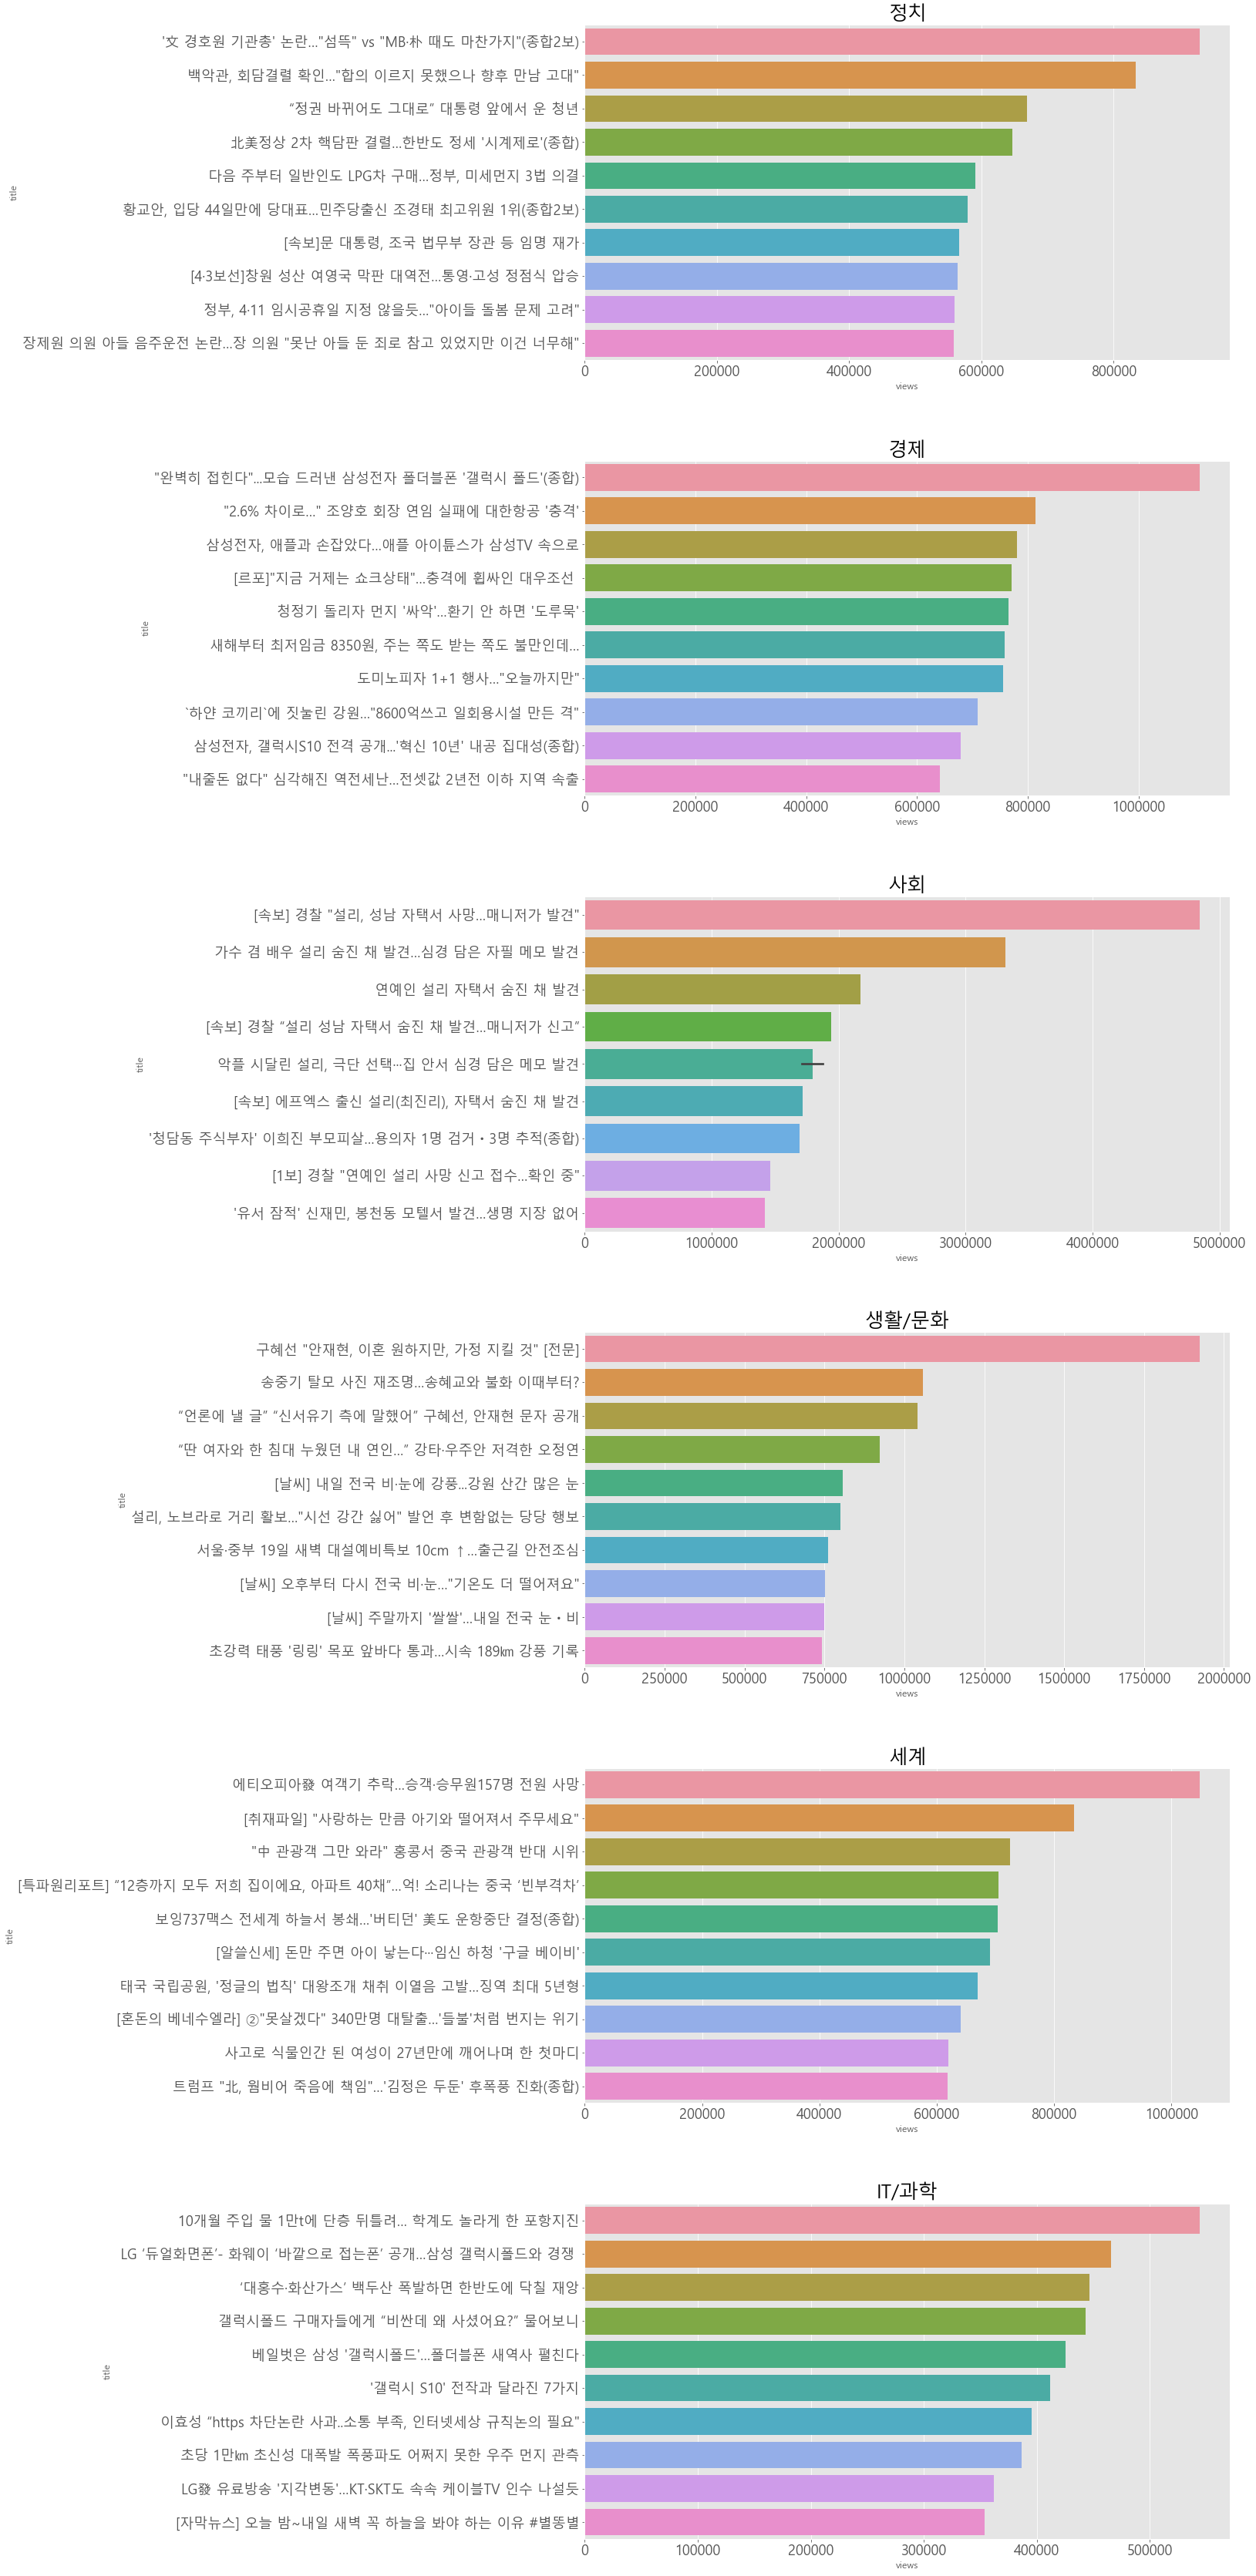

In [13]:
fig, axes = plt.subplots(nrows=6)
fig.set_size_inches(15,60)
plt.subplots_adjust(hspace=0.3)
for idx, section in enumerate(section_label):
    _tv = top_views[top_views['section'] == section].head(10)
    sns.barplot(y="title", x="views", data=_tv, ax=axes[idx])
    axes[idx].set_title(section_label[idx], fontsize=25)
    axes[idx].tick_params(axis='both', labelsize=18)

### 전체 기사 중 댓글 수 TOP 10

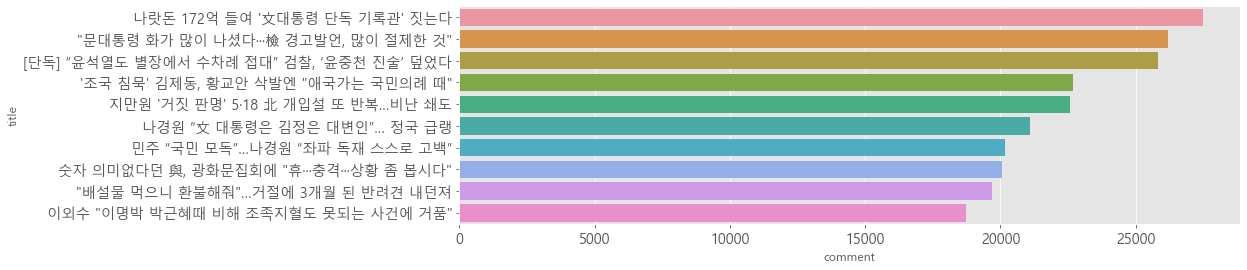

In [14]:
top_comments = df.drop_duplicates('title').sort_values(by='comment', ascending=False)
tc = top_comments.head(10)[["title", "comment"]]
sns.barplot(y="title", x="comment", data=tc)

### 각 섹션별 댓글수 TOP 10

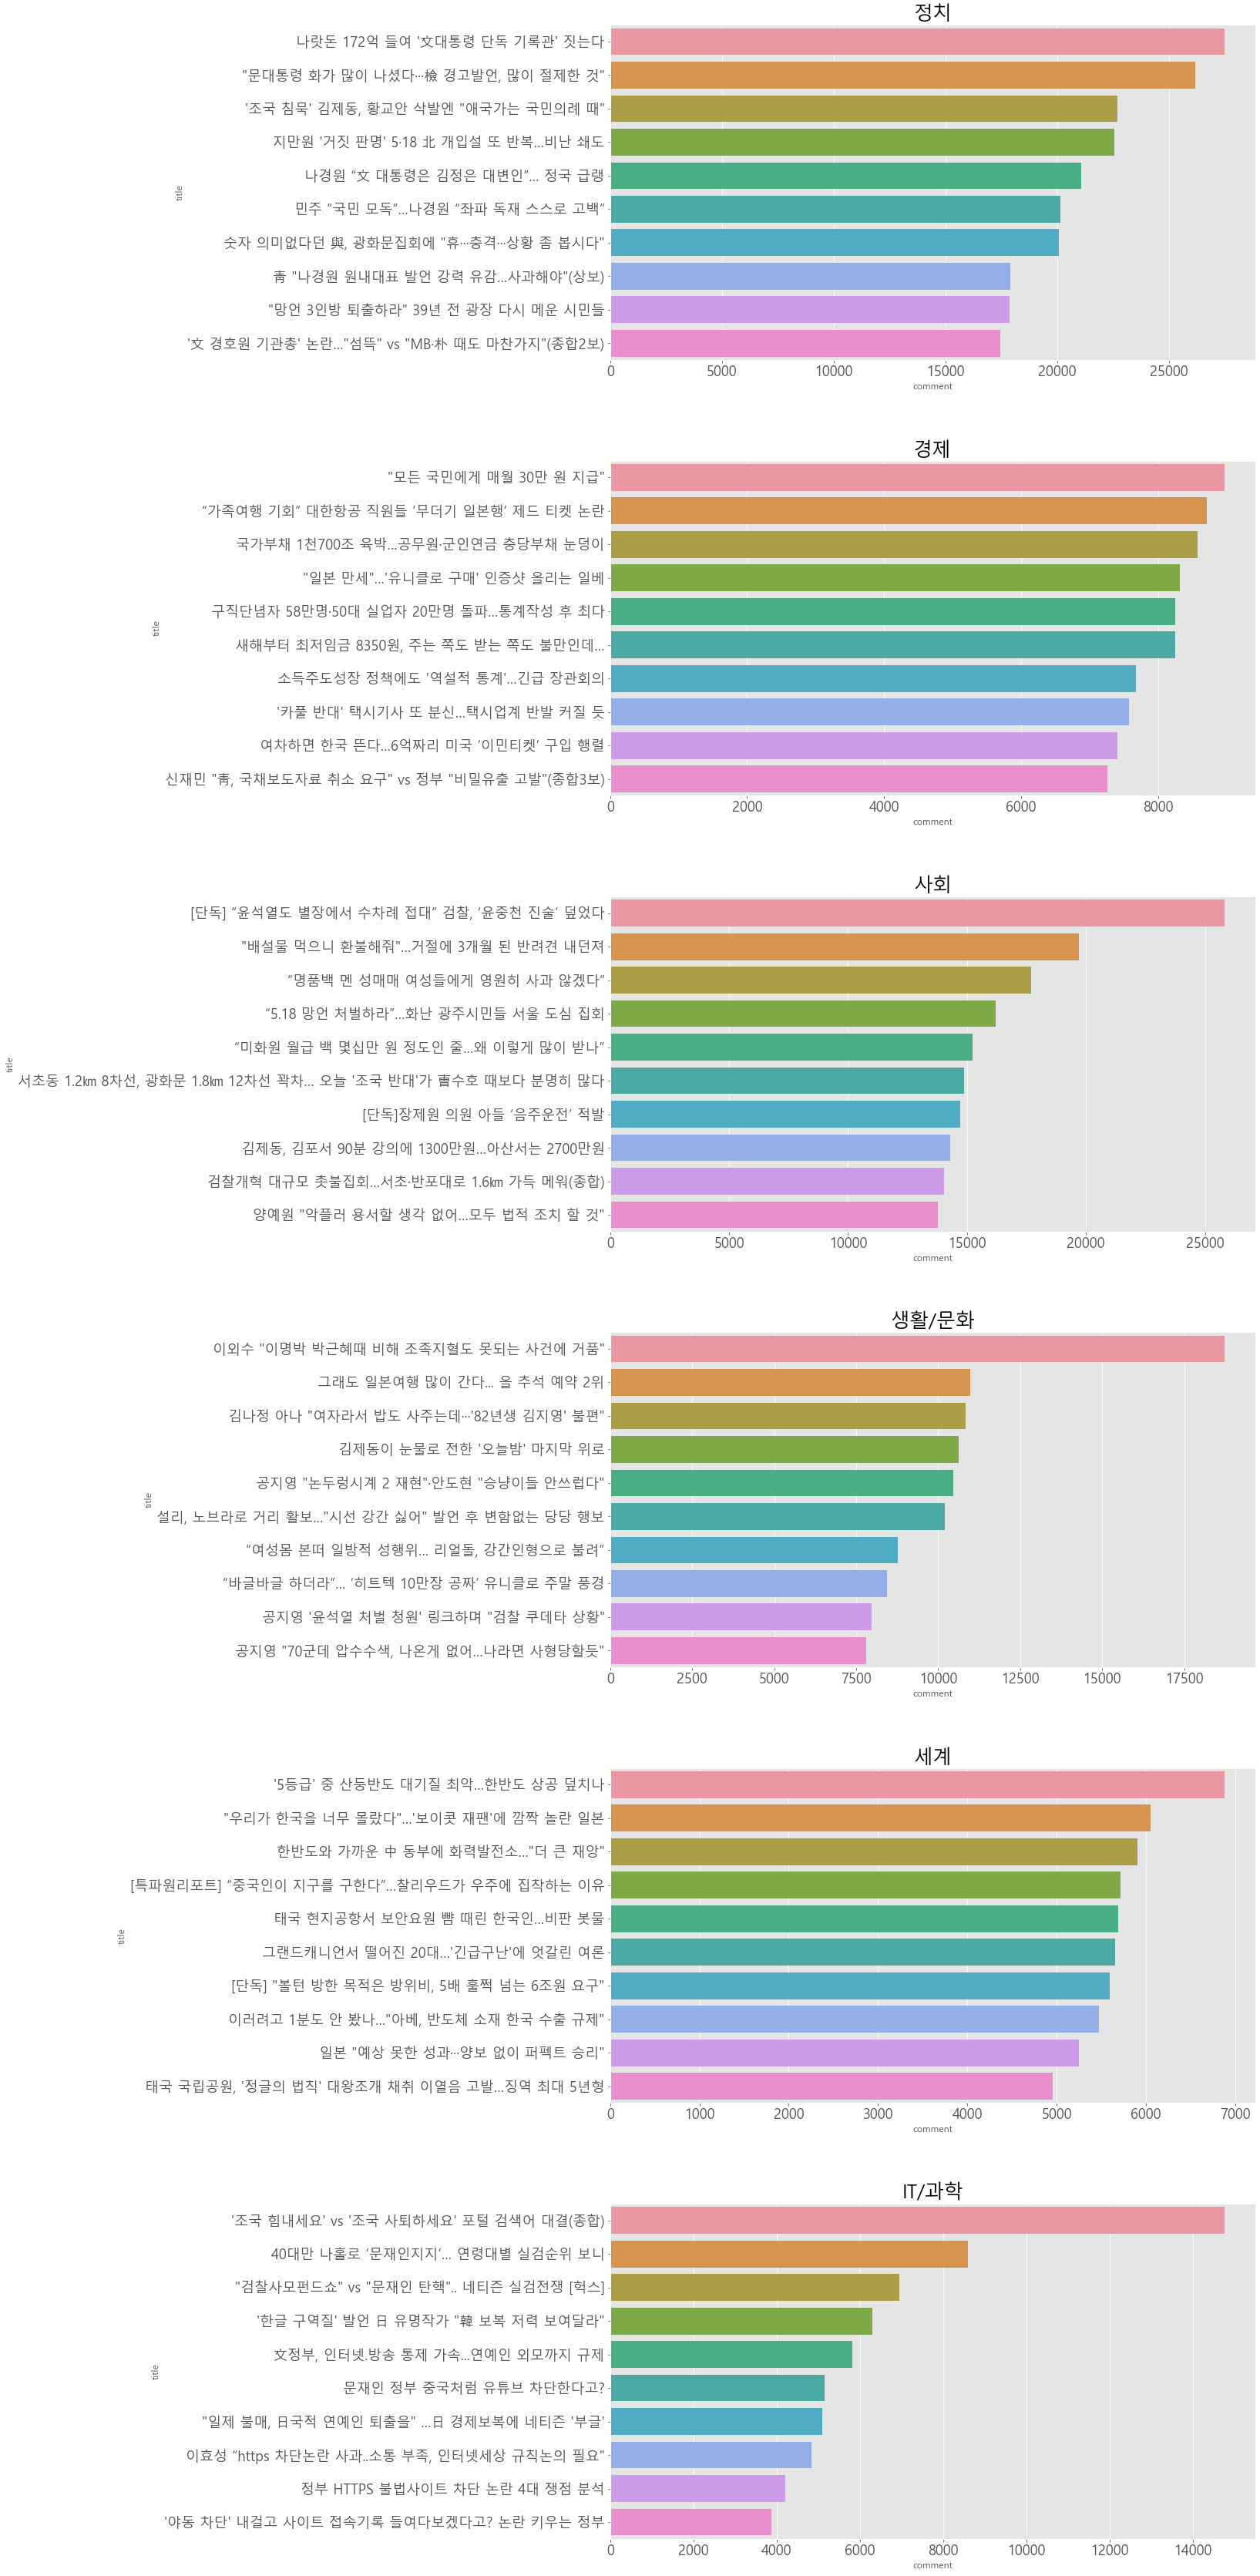

In [15]:
fig, axes = plt.subplots(nrows=6)
fig.set_size_inches(15,60)
plt.subplots_adjust(hspace=0.3)
for idx, section in enumerate(section_label):
    _tc = top_comments[top_comments['section'] == section][['title','comment']].head(10)
    sns.barplot(y="title", x="comment", data=_tc, ax=axes[idx])
    axes[idx].set_title(section_label[idx], fontsize=25)
    axes[idx].tick_params(axis='both', labelsize=18)

- 정치섹션은 문재인 대통령과 조국, 북한에 대한 이슈가 댓글이 가장 많았다.
- 사회섹션에서는 윤석열
- 생활/문화 섹션과 IT/과학 섹션의 1위 기사가 같은 섹션의 다른 기사에 비해 압도적인 댓글 수를 보였다.<br>
  어떤 기사인지 한번 살펴보도록 했다.

In [16]:
pd.options.display.max_colwidth = 150
href1 = top_comments[top_comments['section'] == '생활/문화'].head(1)['href']
href2 = top_comments[top_comments['section'] == 'IT/과학'].head(1)['href']
href1, href2

(44855    https://news.naver.com/main/ranking/read.nhn?rankingType=popular_day&oid=001&aid=0011038058&date=20190825&type=1&rankingSectionId=103&rankingSeq=1
 Name: href, dtype: object,
 42917    https://news.naver.com/main/ranking/read.nhn?rankingType=popular_day&oid=001&aid=0011043424&date=20190827&type=1&rankingSectionId=105&rankingSeq=1
 Name: href, dtype: object)

- 두 기사 모두 조국과 관련된 기사들이다.

### 각 섹션의 월별 조회수, 댓글수

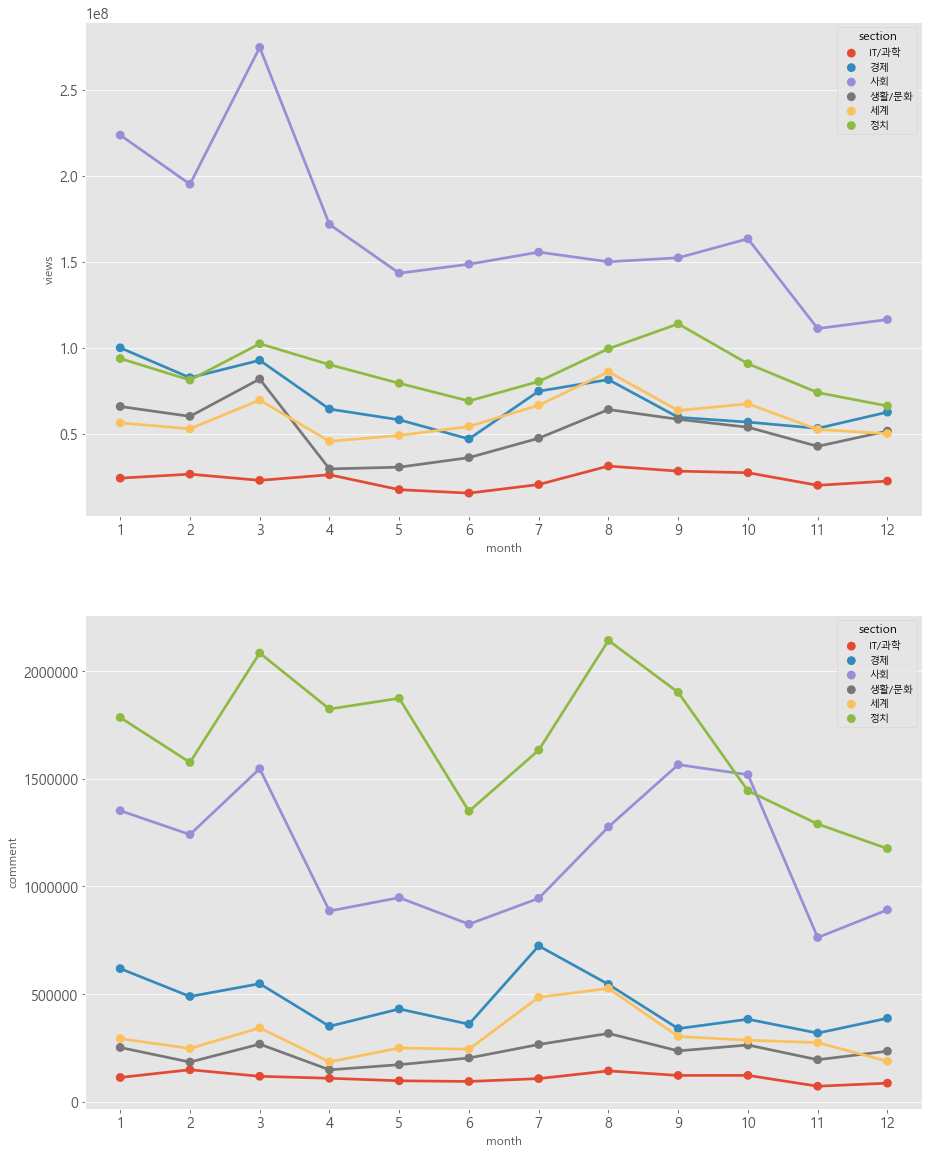

In [17]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(15,20)

temp=df[['section','views','month']].groupby(['section','month']).sum().reset_index()
sns.pointplot(y="views", x="month", hue="section", data = temp, ax=axes[0])

temp2=df.drop_duplicates('title')[['section','comment','month']].groupby(['section','month']).sum().reset_index()
sns.pointplot(y="comment", x="month", hue="section", data = temp2,  ax=axes[1])

- 3월달에 사회 섹션의 조회수가 급증한것을 볼 수 있다. 한번 확인해봅시다

In [18]:
df2 = df.loc[(df['section'] == "사회") & (df['month'] == 3)].sort_values(by='views', ascending=False)
df2.head(10)[['title','views']]

,title,views
14697,'청담동 주식부자' 이희진 부모피살…용의자 1명 검거ㆍ3명 추적(종합),1691871
13338,"[단독] 정준영, 불법 촬영 후 카톡방에 전송…피해자 최소 10명",1391967
14109,"""승리·정준영 카톡방에 언급된 '경찰총장'은 총경급 인사""",1320232
16238,강릉서 승용차 바다에 추락…10대 5명 숨져(종합),1273483
14703,"""이희진 부친 시신, 이삿짐센터 통해 옮겨…5억원 갖고 달아나""(종합)",1254138
13915,"'성관계 몰카' 정준영 ""정말 죄송""…경찰, 구속영장 검토(종합)",1236856
13721,"[단독] 경찰 ""정준영 폰 '복원 불가'로""…증거 인멸 시도",1171920
15084,모텔에 1㎜ 몰카→유료 생중계…투숙객 1600명 당했다,1130878
17001,정준영 손가락 질하며 선 긋지만…당신의 '성'은 괜찮습니까,1102059
16042,"경찰, 이희진 부모살해 피의자 김다운 실명·얼굴 공개(종합)",1059548


<ol>
    <li>버닝썬 관련 정준영 카톡사건
    <li>청담동 주식부자 이희진 부모살해사건
</ol>
두 사건으로인해 3월에 사회섹션 조회수가 급증한것으로 보인다.
<br><br>
- 또한 월별 댓글수 그래프에서 3월, 8월에 정치섹션의 댓글수가 피크를 찍었다. 확인해보자.

In [19]:
df2 = df.drop_duplicates('title').loc[(df['section'] == "정치") & (df['month'] == 3)].sort_values(by='comment', ascending=False)
df2.head(10)[['title','comment']]

,title,comment
9506,나경원 “文 대통령은 김정은 대변인”… 정국 급랭,21090.0
9643,민주 “국민 모독”…나경원 “좌파 독재 스스로 고백”,20153.0
9498,"靑 ""나경원 원내대표 발언 강력 유감…사과해야""(상보)",17918.0
11101,"'文 경호원 기관총' 논란…""섬뜩"" vs ""MB·朴 때도 마찬가지""(종합2보)",17458.0
9650,"나경원 국회 연설에… 靑·與 ""국가원수 모독죄""",15317.0
11109,"""섬뜩한 경호 수칙 위반""…""이전 정부도 똑같이 했다""",14798.0
8064,"文대통령 ""북미대화 완전타결 반드시 성사시켜낼 것""",14479.0
10427,"文대통령 ""제조업 활력 살리는 것이 우리 경제 살리는 길""",14239.0
9255,"이언주 “대통령의 자리, 그렇게 힘든 줄 모르고 올라갔습니까” [황용호의 一筆揮之]",13845.0
10054,"손혜원 ""나경원, 당신 같은 정치인이 함부로 입에 올릴 분 아냐""",13527.0


In [20]:
df2 = df.drop_duplicates('title').loc[(df['section'] == "정치") & (df['month'] == 8)].sort_values(by='comment', ascending=False)
df2.head(10)[['title','comment']]

,title,comment
39378,"文대통령 ""남북경협으로 평화경제 실현해 단숨에 日 따라잡겠다""(종합)",16461.0
39134,"조국, 야당 '이해찬 사케' 공세에 ""전국 일식집 다 망하길 원하나""",16028.0
41073,"[단독]고교때 2주 인턴 조국딸, 의학논문 제1저자 등재",15997.0
39013,"文대통령 ""다시는 日에 지지 않아⋯일본도 큰 피해 감수해야 할 것""",15821.0
40736,"이혼했다던 동생 부부… 주민들 ""보름전까지 같이 사는 것 봤다""",15294.0
39159,"이해찬 '사케 오찬' 논란에 與 ""일식집 하는 국민 망하란거냐""",14365.0
41333,"""정유라 입시는 내란""""공부 말라""던 김제동·강성태 '조국 침묵'",13811.0
39383,"文대통령 ""남북경협으로 평화경제 실현해 日 따라잡을 것""",13773.0
41464,조국 딸 의혹 엄호 나선 민주당 “황교안·나경원 자녀는 문제없나”,13177.0
42053,"6년前 윤병세 딸 '장학금' 논란에...조국 ""난 대학생 딸에게 장학생 신청 하지 말랬다""",13082.0


- 3월달에는 나경원 의원의 문재인 대통령 관련발언 기사가 화제였다.
- 8월달에는 조국 이슈와 문재인 대통령의 일본 수출규제 이슈와 관련해 남북경협 발언기사가 화제였다.

## Reaction 분석
- 긍정적 반응과 부정적 반응의 상대적 비율을 분석한다.
- reaction_good ↔ reaction_angry => positiveness
- reaction_warm ↔ reaction_sad => warmness
- 상반되는 반응을 -50~50의 범위로 나타냄.
- 0에 가까울수록 중립적인 반응을 나타냄
- -50에 가까울수록 부정적, 50에 가까울수록 긍정적 반응

In [21]:
def get_relate(pos, neg):
    if pos+neg != 0:
        return 50 * (pos - neg) / (pos + neg)
    else:
        return 0
    
df['positiveness'] = df.apply(lambda x: get_relate(x['reaction_good'], x['reaction_angry']), axis=1)
df['warmness'] = df.apply(lambda x: get_relate(x['reaction_warm'], x['reaction_sad']), axis=1)
df[['title','positiveness', 'warmness']].head()

,title,positiveness,warmness
0,中탐사선 3일경 달 뒷면 착륙… 우주경쟁서 美 처음 제친다,-27.628032,8.823529
1,오늘부터 최저임금 8350원…근로자 500만명 인상 '역대 최대',-34.724430,0.819672
2,"새해부터 최저임금 8350원, 주는 쪽도 받는 쪽도 불만인데…",-44.742364,-8.196721
3,[리포트+] SNS 연하장 시대…이런 메시지는 공해,-9.358289,-7.894737
4,태양계 끝 날고 소행성 궤도 진입…새해 우주서 잇단 '신기록',35.029940,12.500000


- 우선 너무 적은 수의 reaction으로 positiveness와 warmness를 판단하지 않도록 filter의 기준이 될 median값을 계산해본다.

In [22]:
df2 = df.loc[df['reaction_good'] != -1].dropna()
postiveness_med = np.median(np.add(df2['reaction_good'], df2['reaction_angry']))
postiveness_20 = np.percentile(np.add(df2['reaction_good'], df2['reaction_angry']), 20)
warmness_med = np.median(np.add(df2['reaction_warm'], df2['reaction_sad']))
print(f'중앙값: {postiveness_med}, {warmness_med}')
print(f'positiveness 하위 20%: {postiveness_20}')

중앙값: 347.0, 12.0
positiveness 하위 20%: 64.0


- reaction_good과 reaction_angry의 합이 70개 이상이면 상위 80%내에 속하므로 <br>
100개를 기준으로 filtering한 기사들만 가지고 분포를 알아보자
- warmness는 10개로 filtering하자.

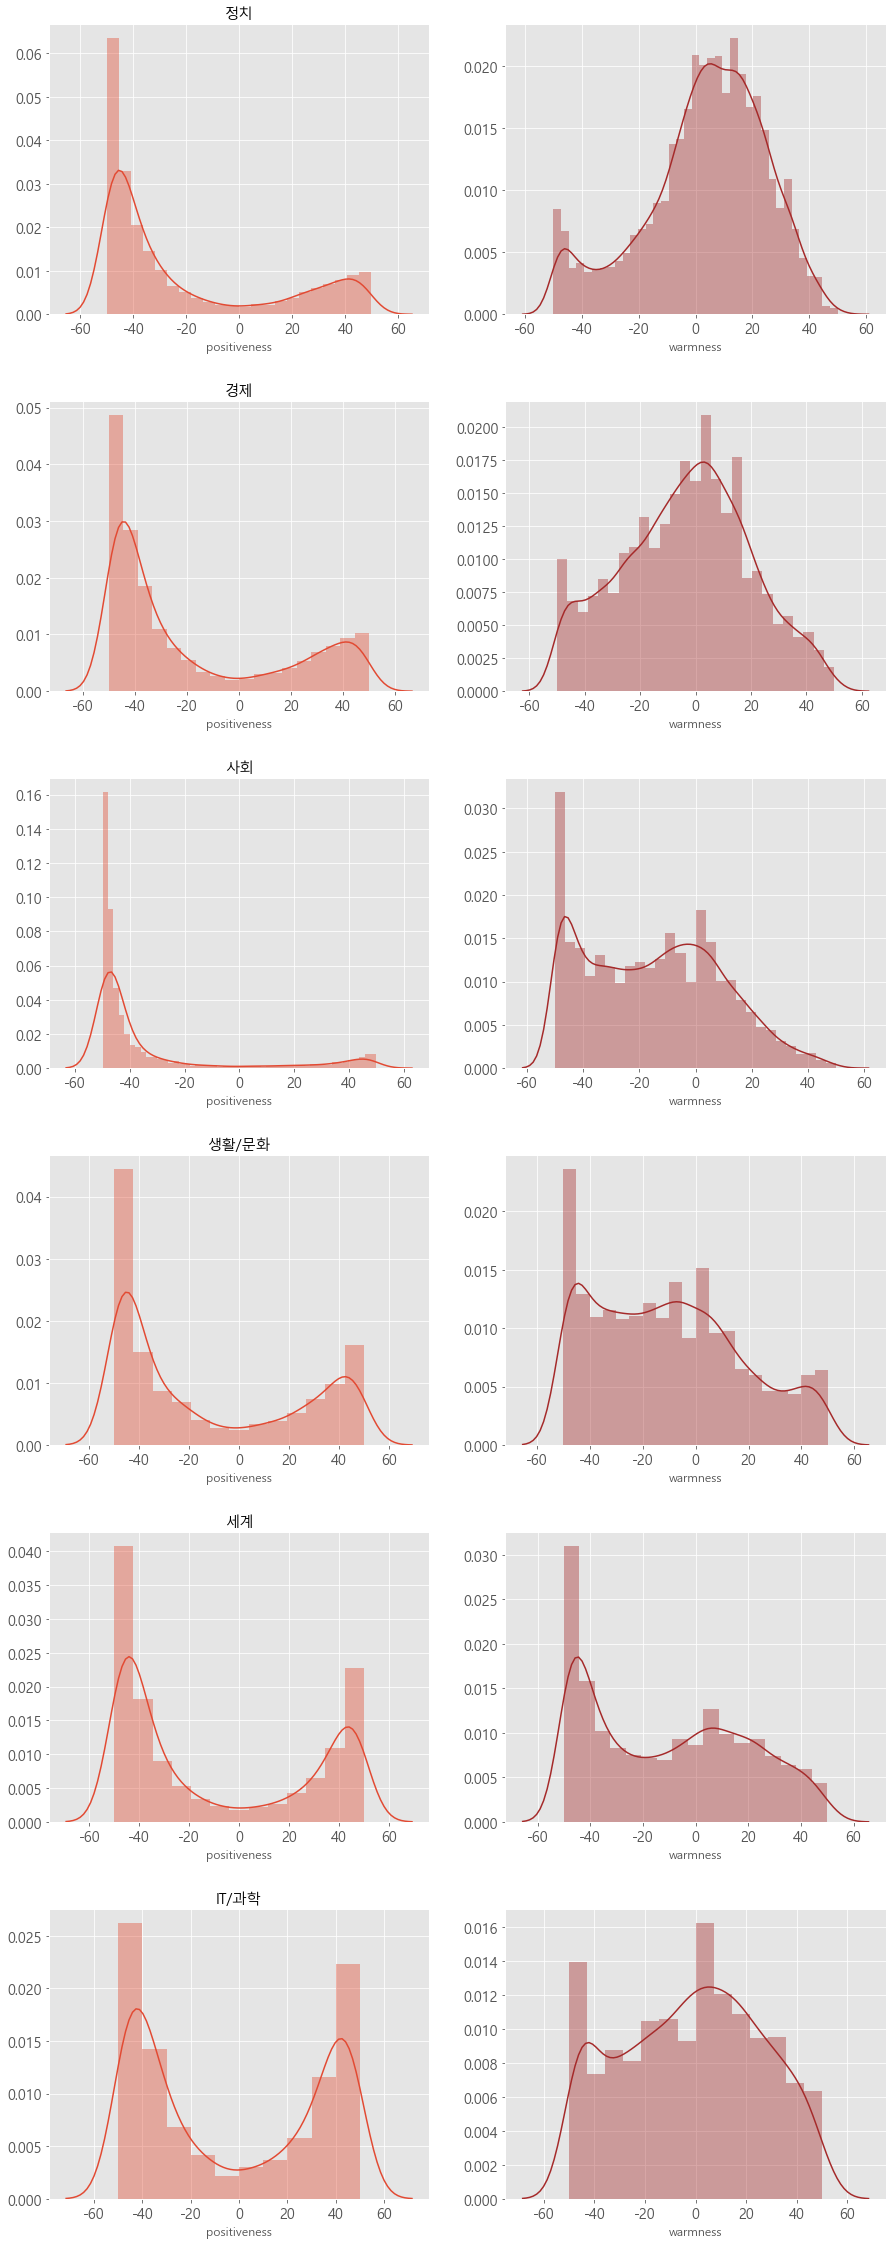

In [23]:
fig, axes = plt.subplots(nrows=6,ncols=2, figsize=(16,10))
fig.set_size_inches(15,40)
plt.subplots_adjust(hspace=0.3)

pos_filtered = df2.loc[df2['reaction_good'] + df2['reaction_angry'] > 100]
warm_filtered = df2.loc[df2['reaction_warm'] + df2['reaction_sad'] > 10]

for idx, section in enumerate(section_label):
    temp = pos_filtered.loc[(pos_filtered['section'] == section)]
    temp2 = warm_filtered.loc[(warm_filtered['section'] == section)]
    sns.distplot(a=temp['positiveness'], ax=axes[idx][0])
    sns.distplot(a=temp2['warmness'], ax=axes[idx][1], color='brown')
    axes[idx][0].set_title(section)

- ### positiveness
> - 정치, 사회, 경제 섹션은 독자들이 긍정적인 반응보다 부정적인 반응을 보인 기사가 훨씬 많고, 극단적인 분포를 보인다.
> - 생활/문화, 세계 섹션 또한 부정적인 반응이 더 많았지만, 극단적인 분포를 보이지는 않았다.
> - iT/과학 섹션이 그나마 분포가 대칭적인 모습을 보인다.
- 독자들은 기사에 대해 오직 한 개의 reaction만을 표할 수 있다.<br> 따라서 상대적으로 reaction_warm, reaction_sad를 누른 횟수가 적으므로, warmness는 그저 참고용으로만 보는게 좋을 것 같다.

위에서 월별 조회수와 댓글수 그래프에서 피크를 기록한 month의 기사를 살펴봤는데,<br>
우리가 계산한 positiveness를 추가해 해당 기사에 대한 사람들의 반응이 어떤지 확인해보자.

#### 3월 사회기사 조회수 TOP10

In [24]:
df2 = df.loc[(df['section'] == "사회") & (df['month'] == 3)].sort_values(by='views', ascending=False)
df2 = df2.head(10)[['title','views', 'positiveness']]
df2.style.bar(subset=['positiveness'], align='mid', color=['#d65f5f', '#5fba7d'])

,title,views,positiveness
14697,'청담동 주식부자' 이희진 부모피살…용의자 1명 검거ㆍ3명 추적(종합),1691871,29.1079
13338,"[단독] 정준영, 불법 촬영 후 카톡방에 전송…피해자 최소 10명",1391967,-48.8249
14109,"""승리·정준영 카톡방에 언급된 '경찰총장'은 총경급 인사""",1320232,-49.0204
16238,강릉서 승용차 바다에 추락…10대 5명 숨져(종합),1273483,-26.3466
14703,"""이희진 부친 시신, 이삿짐센터 통해 옮겨…5억원 갖고 달아나""(종합)",1254138,10.8077
13915,"'성관계 몰카' 정준영 ""정말 죄송""…경찰, 구속영장 검토(종합)",1236856,-48.2579
13721,"[단독] 경찰 ""정준영 폰 '복원 불가'로""…증거 인멸 시도",1171920,-49.1601
15084,모텔에 1㎜ 몰카→유료 생중계…투숙객 1600명 당했다,1130878,-47.6078
17001,정준영 손가락 질하며 선 긋지만…당신의 '성'은 괜찮습니까,1102059,-31.0759
16042,"경찰, 이희진 부모살해 피의자 김다운 실명·얼굴 공개(종합)",1059548,-32.7746


- 정준영 관련 사건에 대해 사람들은 엄청난 분노를 표하고있다.

#### 3월 정치기사 댓글수 TOP10

In [25]:
df2 = df.drop_duplicates('title').loc[(df['section'] == "정치") & (df['month'] == 3)].sort_values(by='comment', ascending=False)
df2 = df2.head(10)[['title','comment','positiveness']]
df2.style.bar(subset=['positiveness'], align='mid', color=['#d65f5f', '#5fba7d'])

,title,comment,positiveness
9506,나경원 “文 대통령은 김정은 대변인”… 정국 급랭,21090,25.6551
9643,민주 “국민 모독”…나경원 “좌파 독재 스스로 고백”,20153,24.9457
9498,"靑 ""나경원 원내대표 발언 강력 유감…사과해야""(상보)",17918,-35.6636
11101,"'文 경호원 기관총' 논란…""섬뜩"" vs ""MB·朴 때도 마찬가지""(종합2보)",17458,-46.6149
9650,"나경원 국회 연설에… 靑·與 ""국가원수 모독죄""",15317,-39.0294
11109,"""섬뜩한 경호 수칙 위반""…""이전 정부도 똑같이 했다""",14798,-44.4238
8064,"文대통령 ""북미대화 완전타결 반드시 성사시켜낼 것""",14479,-35.9248
10427,"文대통령 ""제조업 활력 살리는 것이 우리 경제 살리는 길""",14239,-41.7737
9255,"이언주 “대통령의 자리, 그렇게 힘든 줄 모르고 올라갔습니까” [황용호의 一筆揮之]",13845,35.2871
10054,"손혜원 ""나경원, 당신 같은 정치인이 함부로 입에 올릴 분 아냐""",13527,-43.2175


- 나경원에 대한 문재인 대통령 비판발언에 대해서 옹호하는 사람들이 더 많은것으로 보인다.
- 반면 문재인 대통령의 발언이나, 지지하는 기사에 대해서는 사람들은 부정적인 태도를 보인다.

#### 8월 정치기사 댓글수 TOP10

In [26]:
df2 = df.drop_duplicates('title').loc[(df['section'] == "정치") & (df['month'] == 8)].sort_values(by='comment', ascending=False)
df2 = df2.head(10)[['title','comment','positiveness']]
df2.style.bar(subset=['positiveness'], align='mid', color=['#d65f5f', '#5fba7d'])

,title,comment,positiveness
39378,"文대통령 ""남북경협으로 평화경제 실현해 단숨에 日 따라잡겠다""(종합)",16461,-42.6429
39134,"조국, 야당 '이해찬 사케' 공세에 ""전국 일식집 다 망하길 원하나""",16028,-45.7464
41073,"[단독]고교때 2주 인턴 조국딸, 의학논문 제1저자 등재",15997,-49.4261
39013,"文대통령 ""다시는 日에 지지 않아⋯일본도 큰 피해 감수해야 할 것""",15821,-28.9904
40736,"이혼했다던 동생 부부… 주민들 ""보름전까지 같이 사는 것 봤다""",15294,-49.2914
39159,"이해찬 '사케 오찬' 논란에 與 ""일식집 하는 국민 망하란거냐""",14365,-49.0038
41333,"""정유라 입시는 내란""""공부 말라""던 김제동·강성태 '조국 침묵'",13811,45.1365
39383,"文대통령 ""남북경협으로 평화경제 실현해 日 따라잡을 것""",13773,-40.6762
41464,조국 딸 의혹 엄호 나선 민주당 “황교안·나경원 자녀는 문제없나”,13177,-42.3787
42053,"6년前 윤병세 딸 '장학금' 논란에...조국 ""난 대학생 딸에게 장학생 신청 하지 말랬다""",13082,-49.3516


- 문재인 대통령의 남북경협 발언에 대해 사람들은 반대하는 입장을 보인다.
- 또한 조국 딸의 입시부정 사태에 대해서도 많은 분노를 표출했다.
- 유일하게 postiveness 지수가 높은 기사가 하나 있었다. 확인해보니 평소 정치이슈에 대해 목소리를 냈던 사람들이<br>
이번 조국 딸 입시부정 사건에 대해서는 침묵하자 이를 비판하는 내용의 기사이다. 궁금하면 한번 들어가보시길.

- <a href="https://news.naver.com/main/ranking/read.nhn?rankingType=popular_day&oid=025&aid=0002931795&date=20190823&type=1&rankingSectionId=100&rankingSeq=1">"정유라 입시는 내란""공부 말라"던 김제동·강성태 '조국 침묵'</a>

## 언론사
#### 2019년 네이버 랭킹뉴스 기사들을 작성한 언론사 목록

In [27]:
print(df['press'].drop_duplicates().count())
print(df['press'].drop_duplicates().reset_index(drop=True).to_string())

80
0            동아일보
1             뉴스1
2            JTBC
3             SBS
4            연합뉴스
5            국민일보
6            경향신문
7            세계일보
8             YTN
9            조선비즈
10         연합뉴스TV
11           한국일보
12            한겨레
13            KBS
14           서울신문
15            뉴시스
16            MBC
17           조선일보
18          머니투데이
19           한국경제
20          아시아경제
21           이데일리
22           TV조선
23            채널A
24         파이낸셜뉴스
25           서울경제
26          스포츠경향
27           전자신문
28           시사저널
29          오마이뉴스
30           노컷뉴스
31          코메디닷컴
32           매일경제
33          헤럴드경제
34         디지털타임스
35           데일리안
36         한국경제TV
37    ZDNet Korea
38           문화일보
39            머니S
40         아이뉴스24
41           여성신문
42         디지털데일리
43         동아사이언스
44           헬스조선
45          미디어오늘
46            MBN
47           주간조선
48           중앙일보
49       중앙SUNDAY
50          한겨레21
51            블로터
52           조세일보
53            뉴스엔
54       SBS CNBC
55     

#### 가장 랭킹뉴스 기사가 많은 20개의 언론사를 뽑아서 어떤 섹션의 기사를 많이 작성했는지 알아보자

<Figure size 720x1440 with 0 Axes>

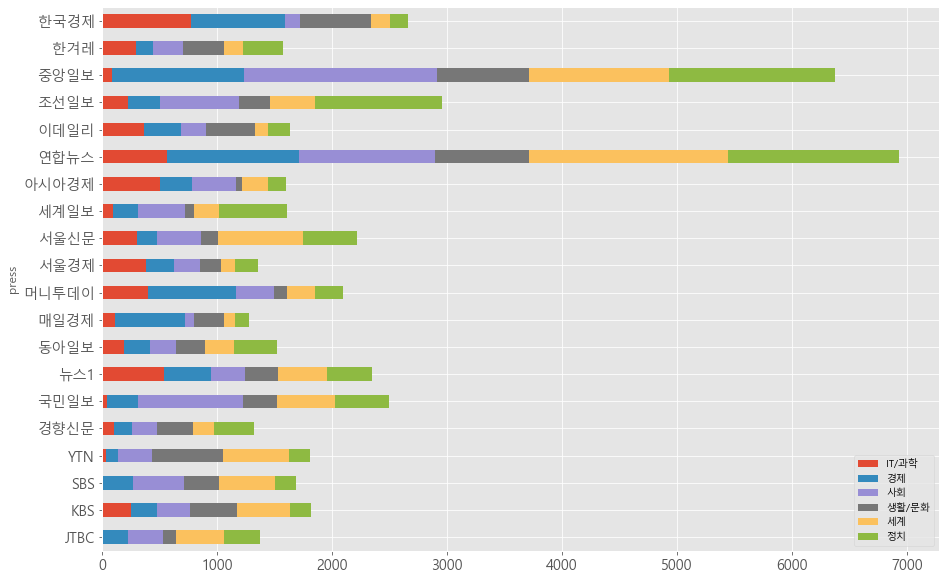

In [28]:
fig = plt.figure()
fig.set_size_inches(10,20)
# 카운팅
temp = df.drop_duplicates('title')[['press', 'section','views','comment']]
temp = temp.groupby(['press','section'])['press'].count().reset_index(name='count')

# 기사 개수를 바탕으로 top20개 언론사 추출
temp2 = temp.groupby('press').sum().sort_values(['count'], ascending=False)
top_press = temp2.head(20).reset_index()['press']

# top20개 언론사만의 데이터를 걸러내어 stacked barplot을 그린다.
temp3 = temp.loc[temp['press'].isin(top_press)].sort_values(['press','count'])
temp3 = temp3.set_index(['press','section']).sort_values('count').unstack()
labels = temp3.columns.get_level_values('section').to_list()
temp3.plot.barh(stacked=True, figsize=(15,10))
plt.legend(labels=labels, loc='lower right')

- 가장 많은 랭킹뉴스 기사를 작성한 TOP3 언론사는 중앙일보, 연합뉴스, 조선일보이다.
- 더불어 이 세 언론사는 정치섹션 기사 TOP3이다.
- 사회섹션 기사를 가장 많이 작성한 언론사는 중앙일보
- 세계섹션 기사를 가장 많이 작성한 언론사는 연합뉴스

- Data들이 머신러닝에 적합한지 테스트
- 향후에 뉴스 제목의 핵심 keyword들을 뽑아 각 데이터와의 관련성을 뽑아내볼 예정.

((array([-4.23215348, -4.02828955, -3.91721632, ...,  3.91721632,
          4.02828955,  4.23215348]),
  array([ 0.        ,  0.        ,  0.        , ..., 10.68802816,
         10.69298982, 10.83141037])),
 (2.151642279728772, 5.019559178653448, 0.9932423803088902))

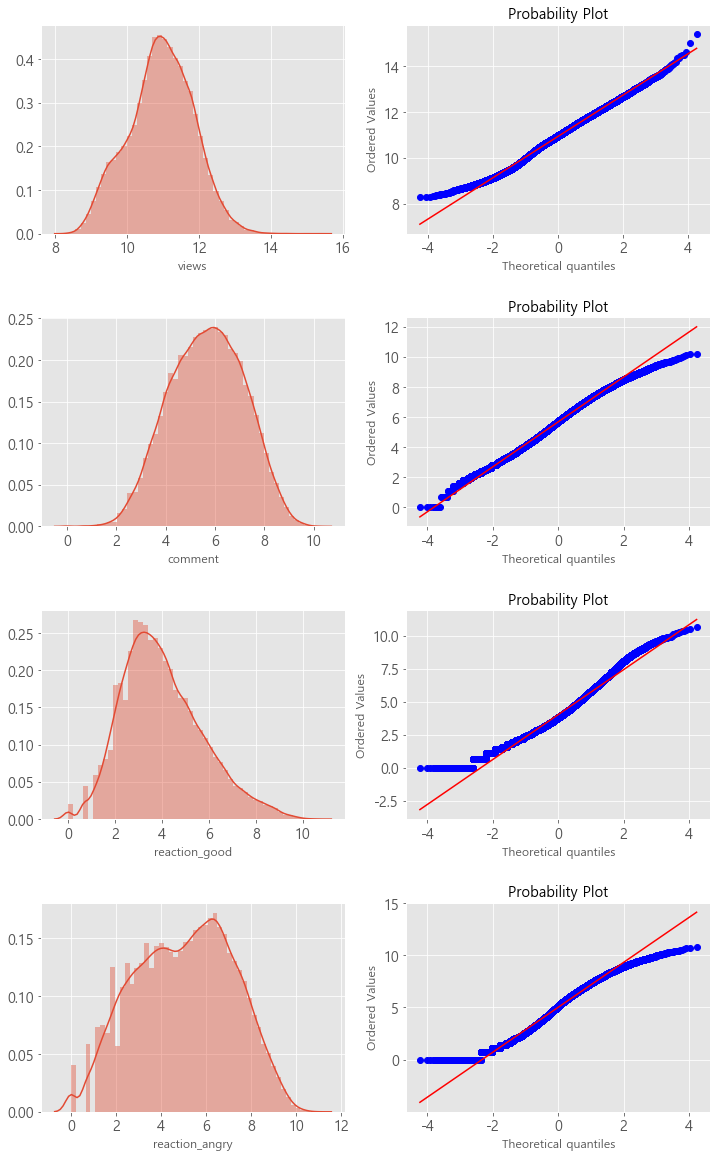

In [29]:
from scipy import stats
figure, axes = plt.subplots(ncols=2, nrows=4)
figure.set_size_inches(12,20)
plt.subplots_adjust(hspace=0.4)

filt_comment = df.loc[df["comment"] != -1].drop_duplicates('title')['comment'].dropna()
filt_react = df.loc[df["reaction_good"] != -1].drop_duplicates('title').dropna()

#조회수
sns.distplot(np.log1p(df["views"]), ax=axes[0][0])
stats.probplot(np.log1p(df["views"]), dist='norm', fit=True, plot=axes[0][1])

#댓글수
sns.distplot(np.log1p(filt_comment), ax=axes[1][0])
stats.probplot(np.log1p(filt_comment), dist='norm', fit=True, plot=axes[1][1])

#긍정적 반응
sns.distplot(np.log1p(filt_react["reaction_good"]), ax=axes[2][0])
stats.probplot(np.log1p(filt_react["reaction_good"]), dist='norm', fit=True, plot=axes[2][1])

#부정적반응
sns.distplot(np.log1p(filt_react["reaction_angry"]), ax=axes[3][0])
stats.probplot(np.log1p(filt_react["reaction_angry"]), dist='norm', fit=True, plot=axes[3][1])